In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.cm as cm  # For colormap

import time


import warnings
warnings.filterwarnings('ignore')

#### Cleaning Data: Gabby's Code

In [173]:
data = pd.read_csv('/Users/parisbozzuti/Desktop/CSAS_challenge/updated_data.csv')
# basic factor
basic_factor_cols = ['game_date', 'game_type','home_team','away_team','type','bb_type','game_year',
                     'pitcher','batter','inning','inning_topbot','pitch_number']


# risk factor
risk_factor_cols = ['game_type','on_3b','on_2b','on_1b','outs_when_up','inning','inning_topbot','woba_value',
                    'home_score','away_score','delta_home_win_exp']


# pitch quality
coords = ['release_pos_x','release_pos_z','pfx_x','pfx_z','plate_x','plate_z']
velocity = ['vx0','vy0','vz0']
acc = ['ax','ay','az']
release = ['release_spin_rate','release_speed','release_extension','release_pos_y','launch_speed_angle','spin_axis','release_pos_x','release_pos_z']
other = ['pitch_type','zone','estimated_ba_using_speedangle','estimated_woba_using_speedangle','woba_value','p_throws','type']
pitch_quality = [col for sublist in [coords, velocity, acc, release, other] for col in sublist]


# reaction
reaction = ['description', 'type', 'bb_type', 'hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle']


# context
context = ['game_type','home_team','away_team','balls','strikes','on_3b','on_2b','on_1b','outs_when_up',
          'inning','inning_topbot','woba_value','woba_denom','pitch_number','home_score','away_score']

relevant_cols = [col for sublist in [basic_factor_cols, risk_factor_cols, pitch_quality, reaction, context] for col in sublist]

full_data = data[relevant_cols].copy()
#full_data.to_csv('full_data.csv',index=False)

### Risk Analysis

In [174]:
data = full_data.copy()
data = data.loc[:, ~data.columns.duplicated()]
print(data[['home_score', 'away_score']].dtypes)


home_score    int64
away_score    int64
dtype: object


In [175]:
data['game_date'] = pd.to_datetime(data['game_date'])

In [176]:
data['lead'] = abs(data['home_score']-data['away_score'])

In [177]:
data['bases_loaded'] = data[['on_3b', 'on_2b', 'on_1b']].notnull().all(axis=1).astype(int)


In [178]:
data.bases_loaded.value_counts()

bases_loaded
0    686548
1     15009
Name: count, dtype: int64

##### Determining Pre-Season, Regular Season, and Post-Season

* Pre-Season: February 14- March 27
* Regular Season: March 28- September 29
* Post-Season: October 1- November 2


In [179]:
def szn(date):
    if pd.Timestamp('2024-02-14') <= date <= pd.Timestamp('2024-03-27'):
        return "Pre-Season"
    elif pd.Timestamp('2024-03-28') <= date <= pd.Timestamp('2024-06-30'):
        return "Regular_Season_March_June"
    elif pd.Timestamp('2024-07-01') <= date <= pd.Timestamp('2024-09-30'):
        return "Regular_Season_July_Sep"
    elif pd.Timestamp('2024-10-01') <= date <= pd.Timestamp('2024-11-02'):
        return "Post_Season"
    else:
        return "Off-Season"

# Apply the function to categorize dates
data['season'] = data['game_date'].apply(szn)

##### Risk Groupings

Level 1:
* Regular Season: March thru June
    * Final innings
    * Significant lead (> 5 runs)
Level 2:
* Regular Season: July thru September
    * Final innings
    * Closer games (2-5 run difference)
    * Wild-Card Qualifiers
    * Games where teams are trying to secure a spot in the post-season
    * bases loaded

Level 3:
* Post Season: October
    * Final games of a series
    * Final innings
    * Ties
    * Final innings
    * Ranking differences
    * bases loaded


In [180]:
data.game_type.value_counts()

game_type
R    688771
D      5182
L      3540
F      2488
W      1576
Name: count, dtype: int64

In [181]:
def calculate_risk(row):
    if row['season']=='Regular_Season_March_June' and (row['inning'] <= 5 or row['lead']>= 5):
        return 1
    elif row['game_type'] == 'F' or (row['season']=='Regular_Season_July_Sep' and (6 <= row['inning'] <= 9) and (strikes > 1 or row['bases_loaded']==1 or (2 <= row['lead'] < 3))):
        return 2
    elif row['game_type'] in ['W', 'L', 'D'] or (row['season']=='Post_Season' and (row['inning'] >= 9 or row['bases_loaded']==1 or row['lead']==0 or row['outs_when_up'] == 2)):
        return 3
    else:
        return 0
    
data['risk'] = data.apply(calculate_risk, axis=1)

In [182]:
data.risk.value_counts()

risk
0    313047
1    230433
2    147779
3     10298
Name: count, dtype: int64

Quick note:

* I have the most data to look at of category 2, which is medium risk- this makes sense. I have the least of category 3 and the second least of category 1. I am okay with that I think. 

In [183]:
risk_data = data.copy()
risk_data = risk_data.drop(risk_data[risk_data['risk'] == 0].index)

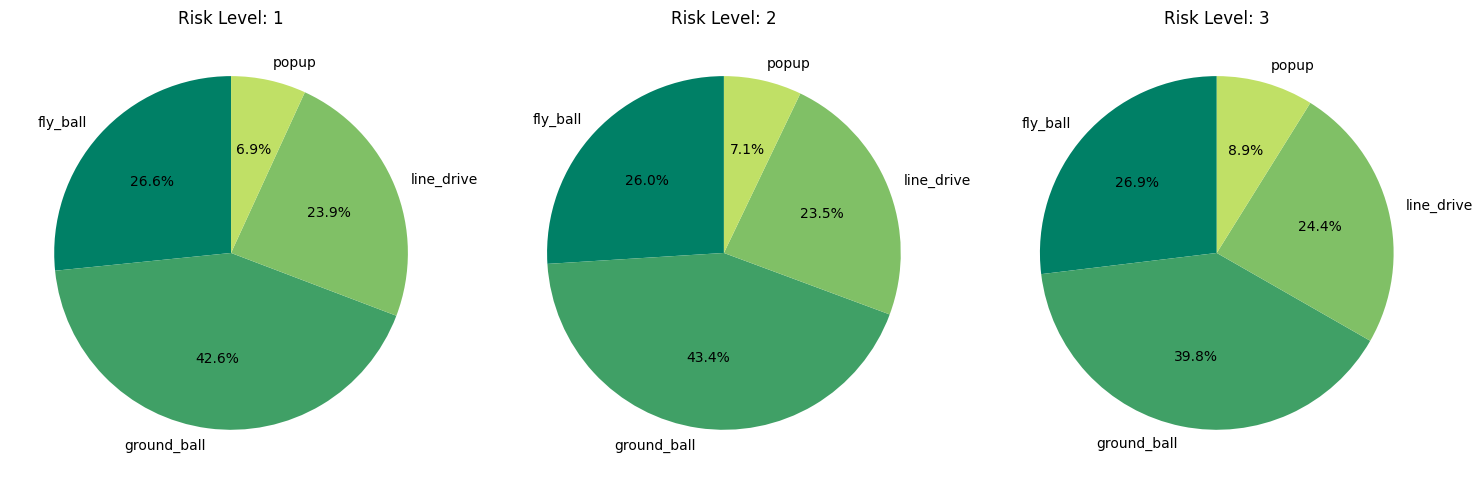

In [184]:
risk_groups = risk_data.groupby('risk')['bb_type'].value_counts()

# Convert the grouped data to a format suitable for plotting
pie_chart_data = risk_groups.unstack(fill_value=0)

cmap = cm.get_cmap('summer')  

# Create pie charts for each 'risk' group
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (risk_level, counts) in zip(axes, pie_chart_data.iterrows()):
    colors = [cmap(i / len(counts)) for i in range(len(counts))]
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f"Risk Level: {risk_level}")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [185]:
risk_data.game_type.value_counts()

game_type
R    375724
D      5182
L      3540
F      2488
W      1576
Name: count, dtype: int64

In [186]:
risk_data.columns

Index(['game_date', 'game_type', 'home_team', 'away_team', 'type', 'bb_type',
       'game_year', 'pitcher', 'batter', 'inning', 'inning_topbot',
       'pitch_number', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'woba_value',
       'home_score', 'away_score', 'delta_home_win_exp', 'release_pos_x',
       'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0',
       'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'release_speed',
       'release_extension', 'release_pos_y', 'launch_speed_angle', 'spin_axis',
       'pitch_type', 'zone', 'estimated_ba_using_speedangle',
       'estimated_woba_using_speedangle', 'p_throws', 'description', 'hc_x',
       'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'balls',
       'strikes', 'woba_denom', 'lead', 'bases_loaded', 'season', 'risk'],
      dtype='object')

In [187]:
risk_data.groupby('risk').describe()['launch_speed']

,count,mean,min,25%,50%,75%,max,std
risk,,,,,,,,
1,77762.0,82.707236,5.1,73.0,82.4,94.60,120.4,15.212119
2,49254.0,82.442845,4.3,73.2,81.9,94.10,120.3,15.027926
3,3259.0,83.674992,12.0,74.1,83.2,95.25,119.5,15.440951


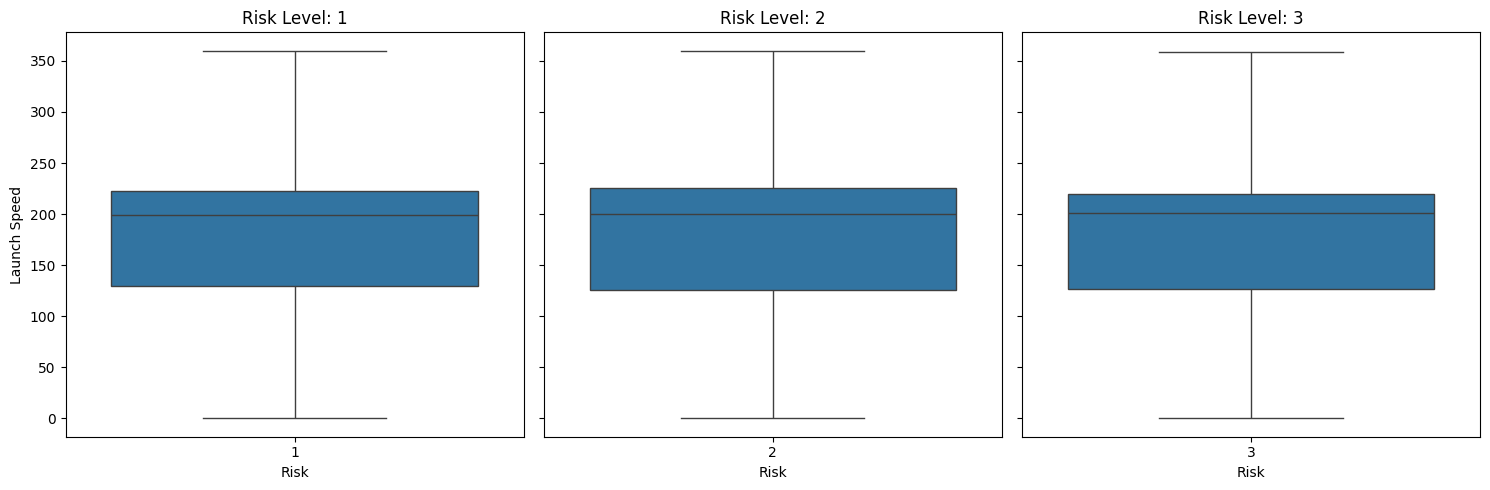

In [188]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot boxplots for each risk group
risk_levels = risk_data['risk'].unique()

for i, risk in enumerate(risk_levels):
    sns.boxplot(
        data=risk_data[risk_data['risk'] == risk],
        x='risk',
        y='spin_axis',
        ax=ax[i]
    )
    ax[i].set_title(f"Risk Level: {risk}")
    ax[i].set_xlabel('Risk')
    ax[i].set_ylabel('Launch Speed' if i == 0 else '')

# Adjust layout
plt.tight_layout()
plt.show()

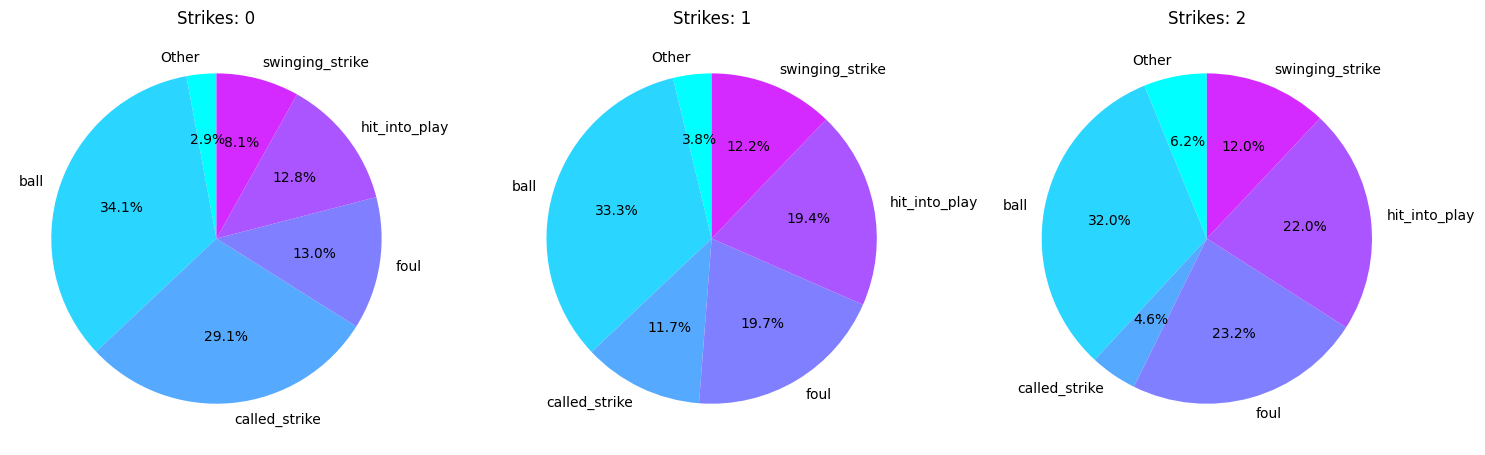

In [190]:
grouped = risk_data.groupby('strikes')['description'].value_counts(normalize=True).unstack(fill_value=0)
grouped = grouped.apply(lambda row: pd.concat([row.nlargest(5), pd.Series({'Other': row.sum() - row.nlargest(5).sum()})]), axis=1)
cmap = cm.get_cmap('cool')  
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (strikes, counts) in zip(axes, grouped.iterrows()):
    colors = [cmap(i / len(counts)) for i in range(len(counts))]
    ax.pie(
        counts, 
        labels=counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors
    )
    ax.set_title(f"Strikes: {strikes}")

# Adjust layout
plt.tight_layout()
plt.show()

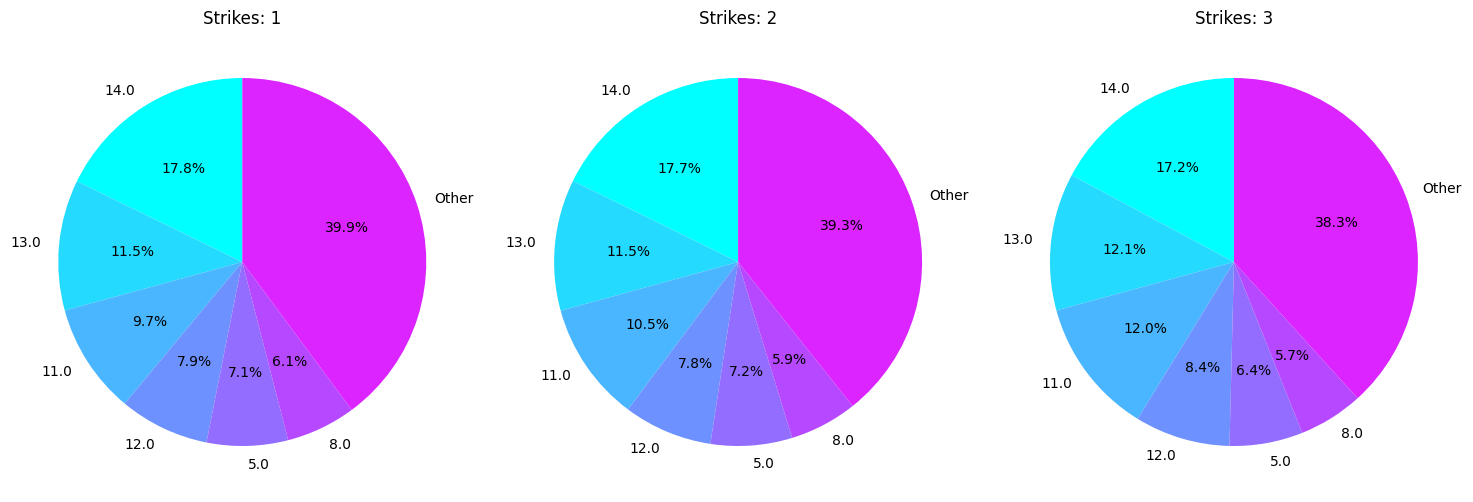

In [195]:
grouped = risk_data.groupby('risk')['zone'].value_counts(normalize=True).unstack(fill_value=0)
grouped = grouped.apply(lambda row: pd.concat([row.nlargest(6), pd.Series({'Other': row.sum() - row.nlargest(5).sum()})]), axis=1)
cmap = cm.get_cmap('cool')  
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (strikes, counts) in zip(axes, grouped.iterrows()):
    colors = [cmap(i / len(counts)) for i in range(len(counts))]
    ax.pie(
        counts, 
        labels=counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors
    )
    ax.set_title(f"Strikes: {strikes}")

# Adjust layout
plt.tight_layout()
plt.show()